# Configs

In [1]:
# pip install --upgrade pandas


In [1]:
# pip install --upgrade pandas xgboost

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json




# Input Paths

In [2]:
model_saved_path = "/tf/users/anurag/kwikathon/kwikathon_model_v1.pkl"
label_encoders_saved_path = "/tf/users/anurag/kwikathon/label_encoder.joblib"
target_encoders_saved_path = "/tf/users/anurag/kwikathon/target_encoder.joblib"
# API endpoints (assuming both APIs are accessible at these URLs)
realtime_api_url = 'https://realtime_api_url.com'  # Realtime Data API
historical_api_url = 'https://historical_api_url.com'  # Historical + Profile API Data
kwikintent_signal_api_url = "https://kwikintent_signal_api_url.com"  

# Historical Data Read

In [3]:
# --------------------------
# STEP 1: Generate synthetic dataset
# --------------------------
np.random.seed(42)
n = 1000  # Number of sessions/users

df = pd.DataFrame({
    'num_of_clicks_on_size_option': np.random.poisson(1, n),
    'num_of_clicks_on_reviews': np.random.poisson(1, n),
    'num_of_clicks_on_images': np.random.poisson(2, n),
    'num_of_clicks_on_offer_section': np.random.poisson(1, n),
    'num_of_clicks_on_return_policy': np.random.binomial(1, 0.2, n),
    'num_of_clicks_on_pincode_deliverability_check': np.random.binomial(1, 0.3, n),
    'num_of_clicks_on_copied_share_product_link': np.random.binomial(1, 0.1, n),
    'num_of_clicks_on_color_variants_selection': np.random.poisson(1, n),
    'num_of_clicks_on_compare_option': np.random.binomial(1, 0.1, n),
    'num_of_clicks_on_read_more_product_description': np.random.binomial(1, 0.15, n),
    'has_hovered_on_atc': np.random.binomial(1, 0.4, n),
    'has_hovered_on_buy_now': np.random.binomial(1, 0.3, n),
    'perc_of_scroll_depth_explored': np.random.uniform(0.1, 1.0, n).round(2),
    'has_zoomed_in_on_product_images': np.random.binomial(1, 0.2, n),
    'session_contains_internal_search': np.random.binomial(1, 0.5, n),
    'num_of_products_viewed_in_session': np.random.randint(1, 15, n),
    'entry_source': np.random.choice(['homepage', 'search', 'ad', 'social','facebook','instagram'], n),
    'location': np.random.choice(['metro', 'tier1', 'tier2', 'tier3'], n),
    'device_type': np.random.choice(['mobile', 'desktop', 'tablet'], n),
    'gender': np.random.choice(['male', 'female', 'other'], n),
    'age': np.random.randint(18, 60, n),
    'num_of_rto_order_in_last_7_days': np.random.poisson(0.2, n),
    'num_of_rto_order_in_last_15_days': np.random.poisson(0.4, n),
    'high_discount_affinity_order_perc_processed': np.random.uniform(0, 1, n).round(2),
    'has credit card': np.random.binomial(1, 0.5, n),
    'uses bnpl': np.random.binomial(1, 0.3, n),
    'preferred_mode_of_payment_processed': np.random.choice(['cod', 'upi', 'card', 'wallet'], n),
    'preferred_order_time': np.random.choice(['morning', 'afternoon', 'evening', 'night'], n),
    'social_source_order_perc_processed': np.random.uniform(0, 0.3, n).round(2),
    'Time between entry and add to cart': np.random.uniform(5, 300, n).round(2),
    'avg_time_between_pdp_page_landing_and_add_to_cart': np.random.uniform(5, 300, n).round(2),
})

# Create Target Column (Multi-Class)

In [4]:
# --------------------------
# STEP 2: Create Target Column (Multi-Class)
# --------------------------
conditions = [
    (df['has_hovered_on_buy_now'] == 1) | (df['has_hovered_on_atc'] == 1),
    (df['num_of_clicks_on_offer_section'] >= 2),
]
choices = ['High Intent', 'Discount Seeker']
df['user_intent'] = np.select(conditions, choices, default='Just Browsing')



# Preprocessing

In [5]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [6]:
# --------------------------
# STEP 3: Preprocessing
# --------------------------
X = df.drop(columns=['user_intent'])
y = df['user_intent']



In [7]:
X.dtypes

num_of_clicks_on_size_option                           int64
num_of_clicks_on_reviews                               int64
num_of_clicks_on_images                                int64
num_of_clicks_on_offer_section                         int64
num_of_clicks_on_return_policy                         int64
num_of_clicks_on_pincode_deliverability_check          int64
num_of_clicks_on_copied_share_product_link             int64
num_of_clicks_on_color_variants_selection              int64
num_of_clicks_on_compare_option                        int64
num_of_clicks_on_read_more_product_description         int64
has_hovered_on_atc                                     int64
has_hovered_on_buy_now                                 int64
perc_of_scroll_depth_explored                        float64
has_zoomed_in_on_product_images                        int64
session_contains_internal_search                       int64
num_of_products_viewed_in_session                      int64
entry_source            

In [8]:
X['has_credit_card'].unique()

array([0, 1])

# Encode categorical features

In [9]:

cat_cols = X.select_dtypes(include='object').columns.tolist()
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le


# Encode target

In [10]:
target_le = LabelEncoder()
y_encoded = target_le.fit_transform(y)



# Train/Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)



# Model Training

In [12]:
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    verbosity=0
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

# Evaluation

Classification Report:
                 precision    recall  f1-score   support

Discount Seeker       1.00      1.00      1.00        20
    High Intent       1.00      1.00      1.00       116
  Just Browsing       1.00      1.00      1.00        64

       accuracy                           1.00       200
      macro avg       1.00      1.00      1.00       200
   weighted avg       1.00      1.00      1.00       200



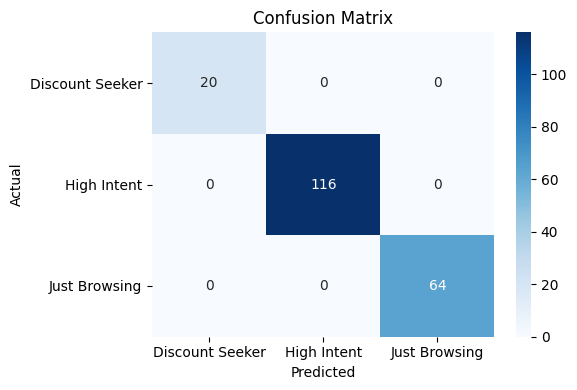

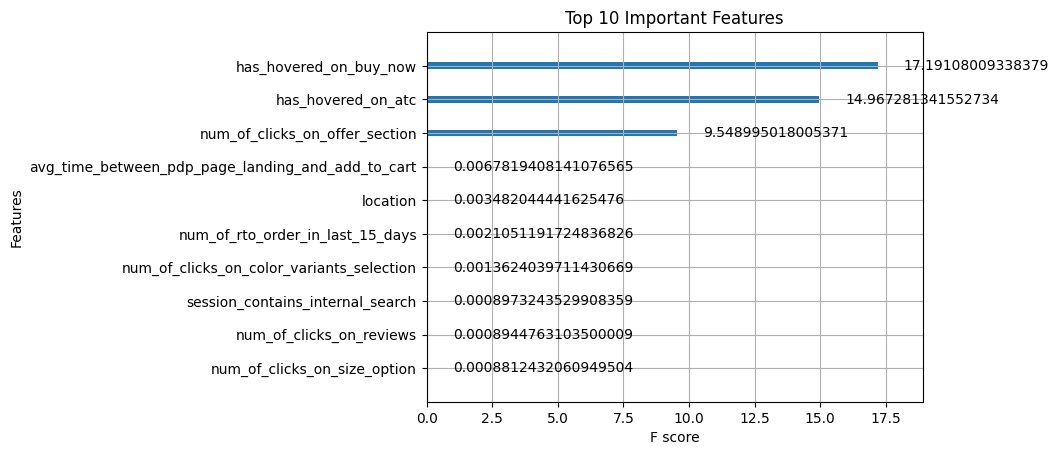

In [13]:

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_le.classes_))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=target_le.classes_, yticklabels=target_le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Feature importance
xgb.plot_importance(model, max_num_features=10, importance_type='gain', title='Top 10 Important Features')
plt.show()



# Save the Model & Encoders

In [14]:
import joblib

joblib.dump(model, model_saved_path)
joblib.dump(label_encoders, label_encoders_saved_path)
joblib.dump(target_le, target_encoders_saved_path)

print("Model Saved Path : " , {model_saved_path})
print("Label Encoder Saved Path : " , {label_encoders_saved_path})

Model Saved Path :  {'/tf/users/anurag/kwikathon/kwikathon_model_v1.pkl'}
Label Encoder Saved Path :  {'/tf/users/anurag/kwikathon/label_encoder.joblib'}


# Inference on New Data

In [3]:
# import requests
# import json
# import joblib


# # Load the model trained & label encoder
# model = joblib.load(model_saved_path)
# label_encoders = joblib.load(label_encoders_saved_path)
# target_le = joblib.load(target_encoders_saved_path)



# # Function to get data from an API
# def get_data_from_api(url):
#     response = requests.get(url)
#     if response.status_code == 200:
#         return response.json()  # Return the JSON data if the request is successful
#     else:
#         raise Exception(f"Failed to retrieve data from API: {response.status_code}")

# # Retrieve data from the two APIs
# #api_data_1 = get_data_from_api(realtime_api_url)  # JSON Data from the first API
# #api_data_2 = get_data_from_api(historical_api_url)  # JSON Data from the second API

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import requests
import json
import joblib


model_saved_path = "/tf/users/anurag/kwikathon/kwikathon_model_v1.pkl"
label_encoders_saved_path = "/tf/users/anurag/kwikathon/label_encoder.joblib"
target_encoders_saved_path = "/tf/users/anurag/kwikathon/target_encoder.joblib"
# API endpoints (assuming both APIs are accessible at these URLs)
# realtime_api_url = 'https://realtime_api_url.com'  # Realtime Data API
# historical_api_url = 'https://historical_api_url.com'  # Historical + Profile API Data
# kwikintent_signal_api_url = "https://kwikintent_signal_api_url.com"  


# Load the model trained & label encoder
model = joblib.load(model_saved_path)
label_encoders = joblib.load(label_encoders_saved_path)
target_le = joblib.load(target_encoders_saved_path)


# Function to get data from an API
def get_data_from_api(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()  # Return the JSON data if the request is successful
    else:
        raise Exception(f"Failed to retrieve data from API: {response.status_code}")


def get_kwikintent_signal(data):
    api_data_1 = data.api_data_1  # JSON Data from the first API
    api_data_2 = data.api_data_2  # JSON Data from the second API
    # Merge both datasets
    merged_data = api_data_1.copy()  # Make a copy of api_data_1
    merged_data.update(api_data_2)  # Update it with the values from api_data_2
    new_user = pd.DataFrame([merged_data])
    new_user = new_user.drop('time_spent_on_pdp',axis=1)
    new_user.columns = new_user.columns.str.replace(' ', '_').str.lower()
    feature_list = model.get_booster().feature_names
    new_user_req = new_user[feature_list]
    cat_cols = new_user_req.select_dtypes(include='object').columns.tolist()
    
    
    # Encode the categorical columns using the same encoders
    for col in cat_cols:
        le = label_encoders[col]
        new_user_req[col] = le.transform(new_user_req[col])
    
    # Predict intent
    pred_class = model.predict(new_user_req)[0]
    pred_label = target_le.inverse_transform([pred_class])[0]
    
    print(f"🧠 Predicted User Intent: **{pred_label}**")
    payload = {'kiwkintent_signal': pred_label}
    headers = {'Content-Type': 'application/json'}
    
    try:
        response = requests.post(kwikintent_signal_output_url, data=json.dumps(payload), headers=headers)
        response.raise_for_status()  # Raise an exception for bad status codes
        print(f"✅ Successfully posted: **{predicted_label}** to {api_url}")
        print(f"Response from API: {response.text}")
    except requests.exceptions.RequestException as e:
        print(f"🚨 Error posting to API: {e}")

# creating dummy data which has to come from above api's
# api_data_1 = {
#   "num_of_clicks_on_size_option": 2,
#   "num_of_clicks_on_reviews": 5,
#   "num_of_clicks_on_images": 3,
#   "num_of_clicks_on_offer_section": 1,
#   "num_of_clicks_on_return_policy": 0,
#   "num_of_clicks_on_pincode_deliverability_check": 1,
#   "num_of_clicks_on_copied_share_product_link": 0,
#   "num_of_clicks_on_color_variants_selection": 2,
#   "num_of_clicks_on_compare_option": 1,
#   "num_of_clicks_on_read_more_product_description": 1,
#   "has_hovered_on_atc": 0,
#   "has_hovered_on_buy_now": 1,
#   "perc_of_scroll_depth_explored": 75.5,
#   "time_spent_on_pdp": 42.8,
#   "has_zoomed_in_on_product_images": 1,
#   "session_contains_internal_search": 0,
#   "num_of_products_viewed_in_session": 8,
#   "entry_source": "facebook",
#   "device_type": "mobile"
# }

# api_data_2 = {
# 'location': 'tier1',
# 'gender': 'male',
# 'age': 28,
# 'num_of_rto_order_in_last_7_days': 0,
# 'num_of_rto_order_in_last_15_days': 1,
# 'high_discount_affinity_order_perc_processed': 0.3,
# 'has credit card': 1,
# 'uses bnpl': 0,
# 'preferred_mode_of_payment_processed': 'upi',
# 'preferred_order_time': 'evening',
# 'social_source_order_perc_processed': 0.12,
# 'Time between entry and add to cart': 60.0,
# 'avg_time_between_pdp_page_landing_and_add_to_cart': 65.0,
# }

In [4]:
# Merge both datasets
merged_data = api_data_1.copy()  # Make a copy of api_data_1
merged_data.update(api_data_2)  # Update it with the values from api_data_2
new_user = pd.DataFrame([merged_data])
new_user = new_user.drop('time_spent_on_pdp',axis=1)
new_user.columns = new_user.columns.str.replace(' ', '_').str.lower()

In [5]:
new_user

,num_of_clicks_on_size_option,num_of_clicks_on_reviews,num_of_clicks_on_images,num_of_clicks_on_offer_section,num_of_clicks_on_return_policy,num_of_clicks_on_pincode_deliverability_check,num_of_clicks_on_copied_share_product_link,num_of_clicks_on_color_variants_selection,num_of_clicks_on_compare_option,num_of_clicks_on_read_more_product_description,...,num_of_rto_order_in_last_7_days,num_of_rto_order_in_last_15_days,high_discount_affinity_order_perc_processed,has_credit_card,uses_bnpl,preferred_mode_of_payment_processed,preferred_order_time,social_source_order_perc_processed,time_between_entry_and_add_to_cart,avg_time_between_pdp_page_landing_and_add_to_cart
0,2,5,3,1,0,1,0,2,1,1,...,0,1,0.3,1,0,upi,evening,0.12,60.0,65.0


In [6]:
len(model.get_booster().feature_names)

31

In [7]:
feature_list = model.get_booster().feature_names
new_user_req = new_user[feature_list]

In [8]:
cat_cols = new_user_req.select_dtypes(include='object').columns.tolist()


# Encode the categorical columns using the same encoders
for col in cat_cols:
    le = label_encoders[col]
    new_user_req[col] = le.transform(new_user_req[col])

# Predict intent
pred_class = model.predict(new_user_req)[0]
pred_label = target_le.inverse_transform([pred_class])[0]

print(f"🧠 Predicted User Intent: **{pred_label}**")



🧠 Predicted User Intent: **High Intent**


# Share the Output to an Endpoint

In [ ]:
payload = {'kiwkintent_signal': predicted_label}
headers = {'Content-Type': 'application/json'}

try:
    response = requests.post(api_url, data=json.dumps(payload), headers=headers)
    response.raise_for_status()  # Raise an exception for bad status codes
    print(f"✅ Successfully posted: **{predicted_label}** to {api_url}")
    print(f"Response from API: {response.text}")
except requests.exceptions.RequestException as e:
    print(f"🚨 Error posting to API: {e}")
